In [27]:
import pandas as pd
import os
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv('train.csv')
df.head()

C:\Users\carlo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.000,NaN
1,1,2013-01-01,25,105574,1.000,NaN
2,2,2013-01-01,25,105575,2.000,NaN
3,3,2013-01-01,25,108079,1.000,NaN
4,4,2013-01-01,25,108701,1.000,NaN


In [4]:
df.date.min()

'2013-01-01'

In [5]:
df.date.max()

'2017-08-15'

In [13]:
df.date = pd.to_datetime(df.date)

In [8]:
items = pd.read_csv('items.csv')
items_family = items[['item_nbr', 'family']].drop_duplicates()

- We merge train.csv and items dataframe to have a single table with sales information and the family attribute

In [9]:
df_items_family = df.merge(items_family, left_on = 'item_nbr', right_on = 'item_nbr', how='left')

In [10]:
# group by family, date and store number because that's the granularity that we aim to explore
df_family = df_items_family.groupby(['family', 'date', 'store_nbr'])['unit_sales'].sum()
df_family = df_family.reset_index()

* We select the top 15 families based on the unit_sales and will forecast for those categories
* Before forecasting, we will group some families together
* We will group the sales in weeks to maximize the amount of timesteps we pass to the model (5 years * 52 weeks a year)

In [18]:
# We build the year_week attribute that will work as the time dimension for the time-series analysis 
df_family['week_number'] = df_family.date.apply(lambda x: pd.Period(x, 'H').week )
df_family.date = pd.to_datetime(df_family.date)
df_family['year'] = df_family.date.dt.year
df_family['year_week'] = df_family.year.astype(str)+df_family.week_number.astype(str).apply(
    lambda x: str('000'+x)[-2:] ).astype(str) 

In [16]:
df_family_grp = df_family.groupby(['family', 'store_nbr', 'year_week'])['unit_sales'].sum().reset_index()

<AxesSubplot:ylabel='family'>

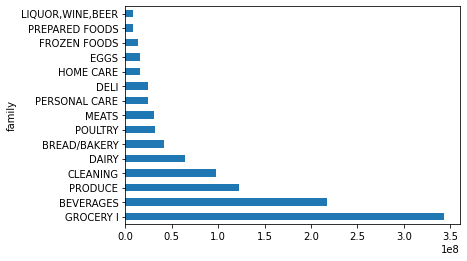

In [17]:
df_family_grp.groupby('family')['unit_sales'].sum().sort_values(ascending=False).head(15).plot(kind='barh')

In [19]:
main_families = df_family_grp.groupby('family')['unit_sales'].sum().sort_values(ascending=False).head(15).index.to_list()

In [20]:
# We group some families into broader categories to cover a higher share of the sales

df_family_grp.loc[df_family_grp.family.isin(['EGGS', 'DAIRY']), 'family'] = 'EGGS_AND_DAIRY'
df_family_grp.loc[df_family_grp.family.isin([ 'FROZEN FOODS','PREPARED FOODS']), 'family'] = 'FROZEN_PREPARED_FOOD'
df_family_grp.loc[df_family_grp.family.isin([ 'POULTRY','MEATS']), 'family'] = 'POULTRY_MEATS'

<AxesSubplot:ylabel='family'>

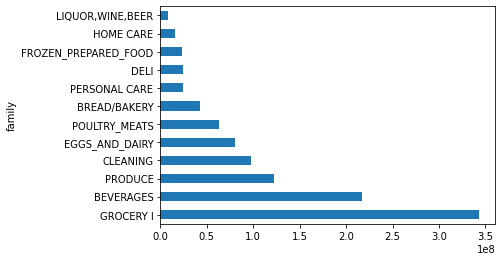

In [21]:
# And group again for the new family labels
df_family_grp = df_family_grp.groupby(['family', 'store_nbr', 'year_week']).sum().reset_index()
df_family_grp.groupby('family')['unit_sales'].sum().sort_values(ascending=False).head(12).plot(kind='barh')

In [22]:
main_families = df_family_grp.groupby('family')['unit_sales'].sum().sort_values(ascending=False).head(12).index.to_list()

- Selection of representative stores per type

In [24]:
# to select the stores, we perform an analysis by type
stores = pd.read_csv('stores.csv')
df_family_grp = df_family_grp.merge(stores[['store_nbr', 'type']])

In [25]:
def show_storetype_sales(df, store_type, smooth_param=5):
    store_type_trend = df[df.type == store_type].groupby(
    ['year_week', 'store_nbr'])['unit_sales'].sum().reset_index()
    
    store_type_trend_p = pd.pivot_table(
    store_type_trend,
    values='unit_sales',
    index='year_week',
    columns='store_nbr',
    aggfunc=np.sum)
    
    store_type_trend_p = store_type_trend_p.rolling(window=smooth_param).mean().dropna()
    
    store_type_trend_p['average_unit_sales'] = store_type_trend_p.mean(axis=1)
    
    store_type_trend_p.plot(figsize=(18, 5), title=f'Unit sales for store type {store_type}')
    
    return store_type_trend_p


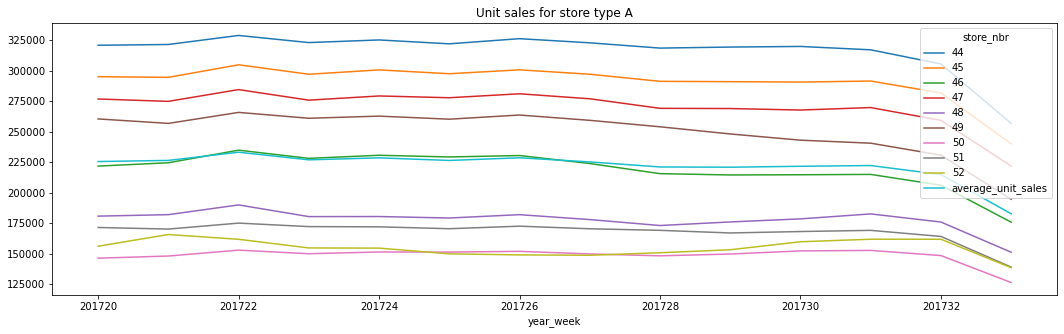

In [29]:
sales_a = show_storetype_sales(df_family_grp, 'A', 5)

- Store number 46 is the representative store for type A.

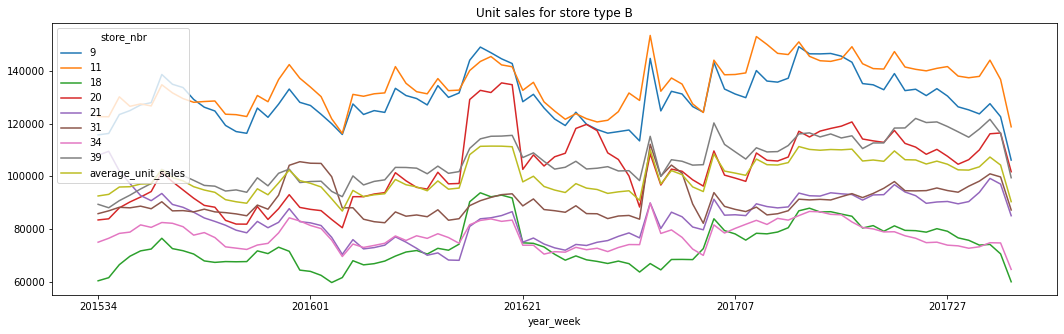

In [30]:
b_sales = show_storetype_sales(df_family_grp, 'B', 5)

- Store number 20 is the most representative for type B

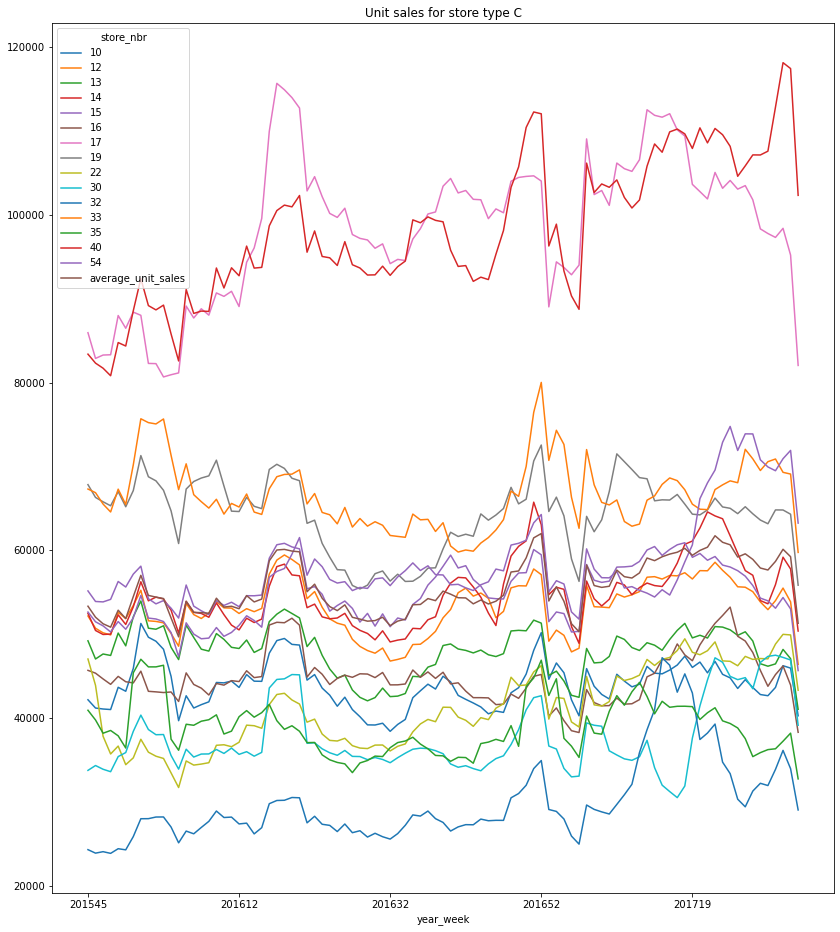

In [139]:
c_sales = show_storetype_sales(df_family_grp, 'C', 5)

<AxesSubplot:xlabel='year_week'>

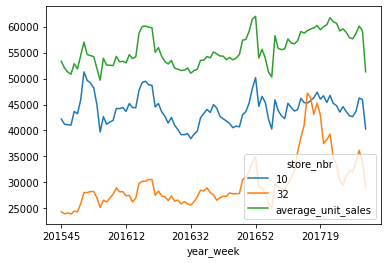

In [148]:
c_sales.iloc[:,[0,10,-1]].plot()

- Store 10 is representative for type C

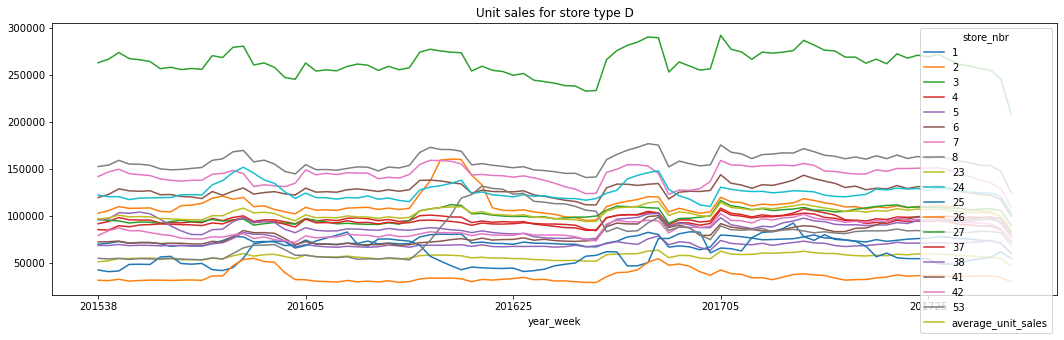

In [31]:
d_sales = show_storetype_sales(df_family_grp, 'D', 5)


- Store 27 representative for type D

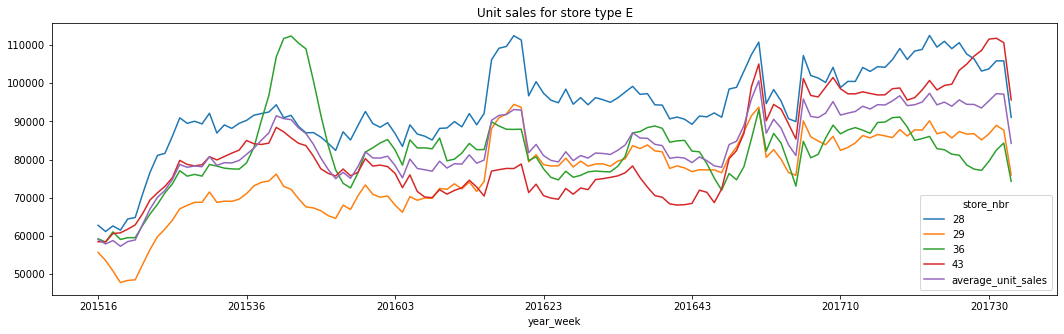

In [32]:
e_sales = show_storetype_sales(df_family_grp, 'E', 5)

- Store 43 is the representative for type E

- Now that we have selected the stores and families, we can create a filtered dataframe

In [33]:
main_families

['GROCERY I',
 'BEVERAGES',
 'PRODUCE',
 'CLEANING',
 'EGGS_AND_DAIRY',
 'POULTRY_MEATS',
 'BREAD/BAKERY',
 'PERSONAL CARE',
 'DELI',
 'FROZEN_PREPARED_FOOD',
 'HOME CARE',
 'LIQUOR,WINE,BEER']

In [34]:
df_family_filt = df_family_grp.loc[ (df_family_grp.store_nbr.isin([43,27,10, 46,20]) ) &
                   (df_family_grp.family.isin(main_families) )]



In [35]:
df_family_filt.to_pickle('family_stores_unit_sales.pkl')
df_family_filt.to_csv('family_stores_unit_sales.csv', index=None)